In [1]:
import numpy as np

In [2]:
def dilser(low=0.001, limit=100.0, dilfactor = 2.0):
    """Returns a list containing a dilution series that ranges from
    "low" to "limit" by "dilfactor".
    """
    a = [low]
    while a[-1] <= limit:
        a.append(a[len(a)-1]*dilfactor)
    
    return np.array(a)


In [3]:
lig = dilser()

a = np.delete(lig,[15,16])

b = np.delete(lig,[14,17])

c = np.delete(lig,[13,15])

ligset = np.array([lig,a,lig,b,c])

In [4]:
rtots = np.array([0.001,0.005, 0.01, 0.02, 0.05])

sim_parms = dict({'k11':3.7, 'k21':1.8, 'k22':0.12, 'l20':293.0})

parmvec = [3.7,1.8,0.12,293.0]

In [5]:
def wyman_sim_parmvec(parm,lig,rtot):
    """ Generates bound fraction for Wyman model given parameters and returns as 
    nested array simulated dataset  
    parm is a 1-D numpy array that must describe [k11,k21,k22,l20]
    lig is a 1-D array or 1-D array of 1-D arrays of ligand concentrations
    rtot is a 1-D numpy array of total receptor concentrations for each data set
    size of rtot and lig must match 
    """
    k11 = parm[0]
    k21 = parm[1]
    k22 = parm[2]
    l20 = parm[3]
    
    holder = []
    
    for i in range(lig.size):
        rfree = (((-1 - k11*lig[i]) + \
        (np.sqrt((1 + k11*lig[i])**2 + 8*l20*rtot[i]*(1 + k21*lig[i] + \
        k21*k22*(lig[i]**2)))))/(4*l20*(1 + k21*lig[i] + k21*k22*(lig[i]**2))))
        
        bfrac = (k11*lig[i] + l20*k21*rfree*lig[i] + \
        2*l20*k21*k22*rfree*(lig[i]**2))/(1 + 2*l20*rfree + k11*lig[i] + \
        2*l20*k21*rfree*lig[i] + 2*l20*k21*k22*rfree*(lig[i]**2))
        
        holder.append(bfrac)
        
    return np.array(holder)

In [6]:
bindset = wyman_sim_parmvec(parmvec,ligset,rtots)

In [7]:
#explicit noise array -- so I can recreate
#note it is set to 3% -- because I am simulating a limited number of data sets
np.random.seed(1776)
noiseset = np.array([np.random.normal(1.0,0.05,bindset[i].size) for i in range(bindset.size)])

In [8]:
bindset_n = noiseset*bindset

In [9]:
%matplotlib inline

In [10]:
import matplotlib.pyplot as plt

In [11]:
clr = ['b','g','r','c','m']

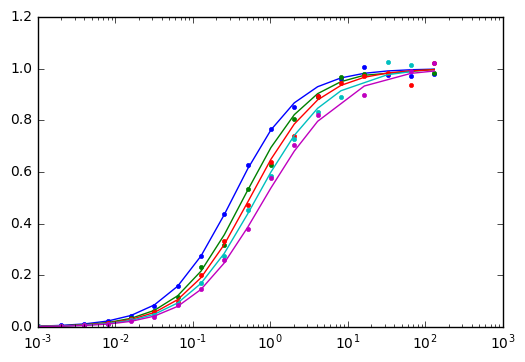

In [12]:
for i in range(bindset_n.size):
    plt.semilogx(ligset[i],bindset_n[i],'.',color=clr[i])
    plt.semilogx(ligset[i],bindset[i],color=clr[i])

In [13]:
#define an objective function for use with lmfit (must mesh with lmfit.Parameter class)
def wyman_obj_lmfit(parm,lig,data,rtot,eps=None):
    """maximizes vector ops"""
    k11 = parm['k11']
    k21 = parm['k21']
    k22 = parm['k22']
    l20 = parm['l20']
    
    ligc = np.concatenate(lig)
    datac = np.concatenate(data)
    
    rfree = (((-1 - k11*ligc)) + \
    (np.sqrt(np.concatenate((np.square((1 + k11*lig)) + \
    8.*l20*rtot*(1 + k21*lig + k21*k22*(np.square(lig)))))))) \
    / (4*l20*(1 + k21*ligc + k21*k22*(np.square(ligc))))    
       
    bfrac = (k11*ligc + l20*k21*rfree*ligc + \
    2*l20*k21*k22*rfree*(np.square(ligc))) \
    / (1 + 2*l20*rfree + k11*ligc + \
    2*l20*k21*rfree*ligc + 2*l20*k21*k22*rfree*(np.square(ligc)))
    
    residual = (bfrac - datac)
    
    if eps is None:
        return residual
    else:
        weights = 1/np.square(np.concatenate(eps))
        return (residual*weights)

In [14]:
#define an objective function for use with lmfit (must mesh with lmfit.Parameter class)
def wyman_obj_lmfit_mod1(parm,lig,data,rtot,eps=None):
    """maximizes vector ops"""
    k11 = parm['k11']
    k21 = parm['k21']
    k22 = parm['k22']
    l20 = parm['l20']
    
    ligc = np.concatenate(lig)
    datac = np.concatenate(data)
    
    rfree = (((-1 - k11*ligc)) + \
    (np.sqrt(np.concatenate((np.square((1 + k11*lig)) + \
    8.*l20*rtot*(1 + k21*lig + k21*k22*(np.square(lig)))))))) \
    / (4*l20*(1 + k21*ligc + k21*k22*(np.square(ligc))))    
       
    bfrac = (k11*ligc + l20*k21*rfree*ligc + \
    2*l20*k21*k22*rfree*(np.square(ligc))) \
    / (1 + 2*l20*rfree + k11*ligc + \
    2*l20*k21*rfree*ligc + 2*l20*k21*k22*rfree*(np.square(ligc)))
    
    residual = (bfrac - datac)
    
    if eps is None:
        return residual
    else:
        weights = 1/np.concatenate(eps)
        return (residual*weights)

In [15]:
import lmfit

In [16]:
parms = lmfit.Parameters()

In [17]:
parms.add('k11', value=10., min=0., max=100.)
parms.add('k21', value=10., min=0., max=100.)
parms.add('k22', value=10., min=0., max=100.)
parms.add('l20', value=100., min=0., max=1000.)

In [18]:
lmfit_min = lmfit.Minimizer(wyman_obj_lmfit,parms,fcn_args=(ligset,bindset_n,rtots))

In [19]:
lmfit_res = lmfit_min.minimize(method='least_squares')

In [20]:
lmfit.report_fit(lmfit_res)

[[Fit Statistics]]
    # function evals   = 21
    # data points      = 84
    # variables        = 4
    chi-square         = 0.023
    reduced chi-square = 0.000
    Akaike info crit   = -679.361
    Bayesian info crit = -669.638
[[Variables]]
    k11:   4.53369549 (init= 10)
    k21:   2.30981701 (init= 10)
    k22:   0.29630900 (init= 10)
    l20:   971.757224 (init= 100)
[[Correlations]] (unreported correlations are <  0.100)


In [21]:
bindset_fit = wyman_sim_parmvec(lmfit_res.x,ligset,rtots)

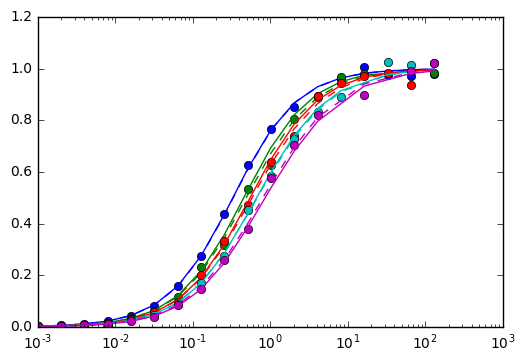

In [22]:
for i in range(bindset_n.size):
    plt.semilogx(ligset[i],bindset_n[i],'o',color=clr[i])
    plt.semilogx(ligset[i],bindset_fit[i],'--',color=clr[i])
    plt.semilogx(ligset[i],bindset[i],color=clr[i])

In [23]:
err = 0.05*bindset_n

In [24]:
lmfit_min_wts = lmfit.Minimizer(wyman_obj_lmfit_mod1,parms,fcn_args=(ligset,bindset_n,rtots,err))

In [25]:
lmfit_res_wts = lmfit_min_wts.minimize()

In [26]:
lmfit.report_fit(lmfit_res_wts)

[[Fit Statistics]]
    # function evals   = 56
    # data points      = 84
    # variables        = 4
    chi-square         = 48.835
    reduced chi-square = 0.610
    Akaike info crit   = -37.558
    Bayesian info crit = -27.835
[[Variables]]
    k11:   3.70295553 +/- 0.199285 (5.38%) (init= 10)
    k21:   1.88618332 +/- 0.084803 (4.50%) (init= 10)
    k22:   0.18859577 +/- 0.058994 (31.28%) (init= 10)
    l20:   347.808209 +/- 91.82645 (26.40%) (init= 100)
[[Correlations]] (unreported correlations are <  0.100)
    C(k11, l20)                  =  0.965 
    C(k21, l20)                  =  0.823 
    C(k11, k21)                  =  0.683 
    C(k22, l20)                  =  0.647 
    C(k21, k22)                  =  0.570 
    C(k11, k22)                  =  0.563 


In [27]:
sim_parms

{'k11': 3.7, 'k21': 1.8, 'k22': 0.12, 'l20': 293.0}

In [28]:
parmsols = np.array([10.,10.,1.,100.])

In [29]:
#define an objective function for use with scipy optimize (obviates parameter class)
#eps is standard deviation
def wyman_obj_vecmin(parm,lig,data,rtot,eps=None):
    k11 = parm[0]
    k21 = parm[1]
    k22 = parm[2]
    l20 = parm[3]
    
    ligc = np.concatenate(lig)
    datac = np.concatenate(data)
    
    rfree = (((-1 - k11*ligc)) + \
    (np.sqrt(np.concatenate((np.square((1 + k11*lig)) + \
    8.*l20*rtot*(1 + k21*lig + k21*k22*(np.square(lig)))))))) \
    / (4*l20*(1 + k21*ligc + k21*k22*(np.square(ligc))))    
       
    bfrac = (k11*ligc + l20*k21*rfree*ligc + \
    2*l20*k21*k22*rfree*(np.square(ligc))) \
    / (1 + 2*l20*rfree + k11*ligc + \
    2*l20*k21*rfree*ligc + 2*l20*k21*k22*rfree*(np.square(ligc)))
    
    residual = (bfrac - datac)

    if eps is None:
        return residual
    else:
        weights = 1/np.square(np.concatenate(eps))
        return (residual*weights)

In [30]:
#define an objective function for use with scipy optimize (obviates parameter class)
#eps is standard deviation
def wyman_obj_vecmin_mod1(parm,lig,data,rtot,eps=None):
    k11 = parm[0]
    k21 = parm[1]
    k22 = parm[2]
    l20 = parm[3]
    
    ligc = np.concatenate(lig)
    datac = np.concatenate(data)
    
    rfree = (((-1 - k11*ligc)) + \
    (np.sqrt(np.concatenate((np.square((1 + k11*lig)) + \
    8.*l20*rtot*(1 + k21*lig + k21*k22*(np.square(lig)))))))) \
    / (4*l20*(1 + k21*ligc + k21*k22*(np.square(ligc))))    
       
    bfrac = (k11*ligc + l20*k21*rfree*ligc + \
    2*l20*k21*k22*rfree*(np.square(ligc))) \
    / (1 + 2*l20*rfree + k11*ligc + \
    2*l20*k21*rfree*ligc + 2*l20*k21*k22*rfree*(np.square(ligc)))
    
    residual = (bfrac - datac)

    if eps is None:
        return residual
    else:
        weights = 1/(np.concatenate(eps))
        return (residual*weights)

In [31]:
from scipy import optimize

In [32]:
bounds=((0.,0.,0.,0.),(100.,100.,100.,1000.))

In [33]:
res_lsq_bounds = optimize.least_squares(wyman_obj_vecmin_mod1,parmsols,bounds=bounds,args=(ligset,bindset_n,rtots))

In [34]:
res_lsq_bounds.x

array([  4.53370698e+00,   2.30981862e+00,   2.96309686e-01,
         9.71766880e+02])

In [35]:
res_lsq_bounds_wts = optimize.least_squares(wyman_obj_vecmin_mod1,parmsols,bounds=bounds,args=(ligset,bindset_n,rtots,err))

In [36]:
res_lsq_bounds_wts.x

array([  3.70295915e+00,   1.88618502e+00,   1.88595736e-01,
         3.47810019e+02])

In [37]:
bindset_fit_wts = wyman_sim_parmvec(res_lsq_bounds_wts.x,ligset,rtots)

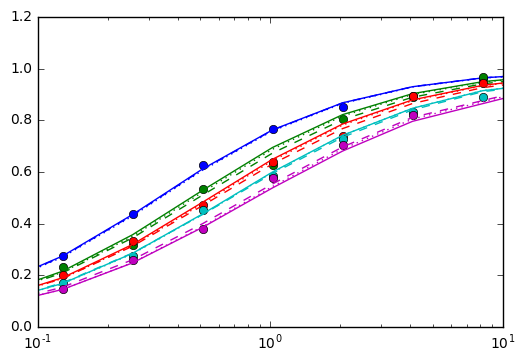

In [38]:
for i in range(bindset_n.size):
    plt.semilogx(ligset[i],bindset_n[i],'o',color=clr[i])
    plt.semilogx(ligset[i],bindset_fit[i],'--',color=clr[i])
    plt.semilogx(ligset[i],bindset_fit_wts[i],':',color=clr[i])
    plt.semilogx(ligset[i],bindset[i],color=clr[i])
    plt.xlim(0.1,10)

In [85]:
def lnprob_vec(parm,lig,data,rtot,eps):
    return -0.5 * np.sum((wyman_obj_vecmin_mod1(parm,lig,data,rtot,eps))**2 + np.log(np.concatenate(2 * np.pi * eps**2)))

In [86]:
def nll(parm,lig,data,rtot,eps):
    return -1*lnprob_vec(parm,lig,data,rtot,eps)

In [87]:
bnds = ((0,100),(0,100),(0,100),(0,1000))

In [88]:
optimize.minimize(nll,parmsols,args=(ligset,bindset_n,rtots,err), bounds=bnds)

      fun: -320.49126403068828
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -1.56319402e-03,  -1.31876732e-03,  -6.48014975e-04,
         1.70530257e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 220
      nit: 27
   status: 0
  success: True
        x: array([  3.70289636e+00,   1.88616232e+00,   1.88583737e-01,
         3.47781068e+02])

In [89]:
def lnprior(parms,bounds):
    k11,k21,k22,l20 = parms
    k11_lo = bounds[0][0]
    k11_hi = bounds[0][1]
    k21_lo = bounds[1][0]
    k21_hi = bounds[1][1]
    k22_lo = bounds[2][0]
    k22_hi = bounds[2][1]
    l20_lo = bounds[3][0]
    l20_hi = bounds[3][1]
    if k11_lo < k11 < k11_hi and k21_lo < k21 < k22_hi and k22_lo < k22 < k22_hi and l20_lo < l20 < l20_hi:
        return 0.0
    return -np.inf
 

In [90]:
outparm = [1.,1.,1.,10000.]

In [92]:
lnprior(parmvec,bnds)

0.0

In [93]:
bnds[0][0]

0

In [55]:
sim_parms

{'k11': 3.7, 'k21': 1.8, 'k22': 0.12, 'l20': 293.0}

In [94]:
def lnprob_jn(parm,lig,data,rtot,eps,bounds):
    lp = lnprior(parm,bounds)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnprob_vec(parm,lig,data,rtot,eps)

In [95]:
lnprob_jn(parmvec,ligset,bindset_n,rtots,err,bnds)

318.01150842777258

In [97]:
lnprob_vec(parmvec,ligset,bindset_n,rtots)

TypeError: lnprob_vec() missing 1 required positional argument: 'eps'

In [98]:
resul = optimize.minimize(nll,parmsols,args=(ligset,bindset_n,rtots,err), bounds=bnds)

In [99]:
resul["x"]

array([  3.70289636e+00,   1.88616232e+00,   1.88583737e-01,
         3.47781068e+02])

In [100]:
resul.x

array([  3.70289636e+00,   1.88616232e+00,   1.88583737e-01,
         3.47781068e+02])

In [103]:
ndim, nwalkers = 4, 100

In [113]:
pos = [resul.x + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

In [157]:
pos1 = [resul.x + 1e-2*np.random.randn(ndim) for i in range(nwalkers)]

In [114]:
import emcee

In [115]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_jn, args=(ligset,bindset_n,rtots,err,bnds))

In [118]:
sampler.run_mcmc(pos, 1000)

(array([[  3.70106477e+00,   1.80540181e+00,   1.03223070e-01,
           3.16395018e+02],
        [  3.97227153e+00,   1.89729487e+00,   1.47024038e-01,
           4.55087973e+02],
        [  3.69888496e+00,   1.83571066e+00,   1.82798981e-01,
           3.19096008e+02],
        [  3.71159647e+00,   1.86141021e+00,   2.07596363e-01,
           3.49956296e+02],
        [  3.69000924e+00,   1.80147536e+00,   1.38206181e-01,
           3.27858484e+02],
        [  4.00795094e+00,   2.04184547e+00,   2.42850607e-01,
           5.50812727e+02],
        [  3.91685090e+00,   1.83685152e+00,   1.67718309e-01,
           4.23333619e+02],
        [  3.76540833e+00,   1.86411783e+00,   3.34254959e-01,
           3.91628950e+02],
        [  3.62416175e+00,   1.85365877e+00,   1.82387930e-01,
           3.10094763e+02],
        [  4.13533614e+00,   1.88373050e+00,   2.14216950e-01,
           5.06623982e+02],
        [  3.61068275e+00,   1.97521479e+00,   3.71329401e-01,
           3.76901068e+02],

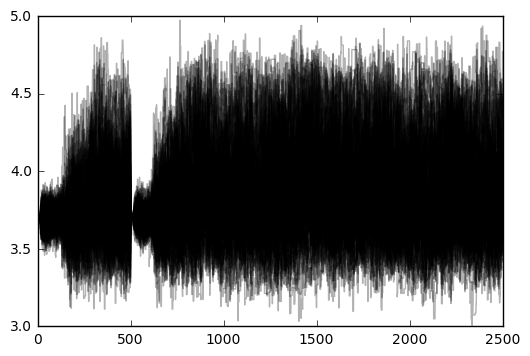

In [123]:
plt.plot(sampler.chain[:,:,0].T, '-', color='k', alpha=0.3);

In [124]:
def lnprob_lmfit(parm,lig,data,rtot,eps):
    return -0.5 * np.sum((wyman_obj_lmfit_mod1(parm,lig,data,rtot,eps))**2 + np.log(np.concatenate(2 * np.pi * eps**2)))

In [126]:
lnprob_lmfit(parms,ligset,bindset_n,rtots,err)

-71413.080963110391

In [127]:
lnprob_vec(parmsols,ligset,bindset_n,rtots,err)

-57230.756972024901

In [129]:
parmsols[2] = 10.

In [130]:
lnprob_vec(parmsols,ligset,bindset_n,rtots,err)

-71413.080963110391

In [131]:
lmfit_res_wts.params

Parameters([('k11',
             <Parameter 'k11', value=3.7029555297315331 +/- 0.199, bounds=[0.0:100.0]>),
            ('k21',
             <Parameter 'k21', value=1.8861833215154444 +/- 0.0848, bounds=[0.0:100.0]>),
            ('k22',
             <Parameter 'k22', value=0.18859577842798569 +/- 0.059, bounds=[0.0:100.0]>),
            ('l20',
             <Parameter 'l20', value=347.80820926833383 +/- 91.8, bounds=[0.0:1000.0]>)])

In [134]:
mini = lmfit.Minimizer(lnprob_lmfit, lmfit_res_wts.params, fcn_args=(ligset,bindset_n,rtots,err))

In [135]:
res = mini.emcee()

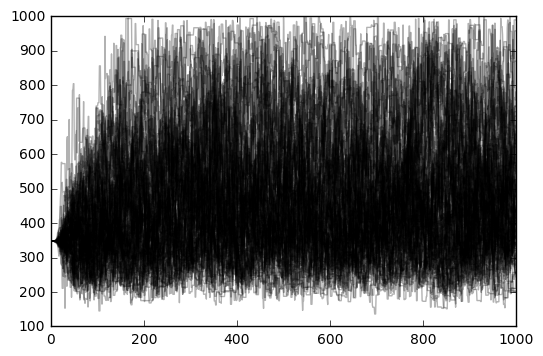

In [141]:
plt.plot(res.chain[:,:,3].T, '-', color='k', alpha=0.3);

In [142]:
import cProfile

In [196]:
mini1 = lmfit.Minimizer(lnprob_lmfit, lmfit_res_wts.params, fcn_args=(ligset,bindset_n,rtots,err))
cProfile.run('res1=mini1.emcee(steps=2000)')

         34892524 function calls (34892508 primitive calls) in 128.716 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   189901    6.760    0.000  104.072    0.001 <ipython-input-124-bf8e9cd493f0>:1(lnprob_lmfit)
   189901   49.911    0.000   93.914    0.000 <ipython-input-14-07239b8ac76b>:2(wyman_obj_lmfit_mod1)
        1    0.000    0.000  128.716  128.716 <string>:1(<module>)
   379801    0.294    0.000    2.932    0.000 _methods.py:31(_sum)
   411307    0.250    0.000    2.439    0.000 _methods.py:37(_any)
        1    0.000    0.000    0.000    0.000 _methods.py:43(_count_reduce_items)
        1    0.000    0.000    0.004    0.004 _methods.py:53(_mean)
      390    0.000    0.000    0.000    0.000 asteval.py:104(<genexpr>)
        9    0.000    0.000    0.000    0.000 asteval.py:108(<genexpr>)
       41    0.000    0.000    0.000    0.000 asteval.py:113(<genexpr>)
        1    0.000    0.000    0.000    0.000 asteval.

In [195]:
res1

In [197]:
sampler1 = emcee.EnsembleSampler(nwalkers, ndim, lnprob_jn, args=(ligset,bindset_n,rtots,err,bnds))
cProfile.run('sampler1.run_mcmc(pos, 2000)')

         2913406 function calls in 50.437 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   190824   34.272    0.000   37.038    0.000 <ipython-input-30-1ff109855aa1>:3(wyman_obj_vecmin_mod1)
   190824    6.137    0.000   46.039    0.000 <ipython-input-85-d1d972ffee81>:1(lnprob_vec)
   200100    1.515    0.000    1.515    0.000 <ipython-input-89-c443bcdc9d2f>:1(lnprior)
   200100    1.062    0.000   48.615    0.000 <ipython-input-94-a1137b75076b>:1(lnprob_jn)
        1    0.000    0.000   50.437   50.437 <string>:1(<module>)
   190824    0.131    0.000    1.361    0.000 _methods.py:31(_sum)
    16004    0.011    0.000    0.111    0.000 _methods.py:37(_any)
     2001    0.215    0.000   50.434    0.025 ensemble.py:130(sample)
     4000    0.281    0.000   50.094    0.013 ensemble.py:292(_propose_stretch)
     4001    0.450    0.000   49.694    0.012 ensemble.py:340(_get_lnprob)
     4001    0.067    0.000    0.067    0.000 

In [158]:
sampler3 = emcee.EnsembleSampler(nwalkers, ndim, lnprob_jn, args=(ligset,bindset_n,rtots,err,bnds))

In [161]:
sampler3.run_mcmc(pos1,2000);

(array([[  3.69259903e+00,   1.86484952e+00,   2.33980203e-01,
           3.62319609e+02],
        [  3.86245267e+00,   1.91404284e+00,   9.68590401e-02,
           3.96775134e+02],
        [  3.95829392e+00,   2.08277571e+00,   2.10922399e-01,
           5.77658067e+02],
        [  3.98602772e+00,   2.03243881e+00,   2.69267207e-01,
           5.29121886e+02],
        [  4.04026976e+00,   2.02119375e+00,   3.15743043e-01,
           5.32539954e+02],
        [  3.72269338e+00,   1.97410624e+00,   2.23706131e-01,
           3.64918157e+02],
        [  4.41808559e+00,   1.97053923e+00,   1.84331128e-01,
           6.92463503e+02],
        [  4.17361493e+00,   1.98363031e+00,   2.66319535e-01,
           6.36449999e+02],
        [  3.70860863e+00,   1.96061246e+00,   3.59954422e-01,
           3.94085823e+02],
        [  3.65428373e+00,   1.95513760e+00,   2.20182594e-01,
           3.35873778e+02],
        [  3.94757894e+00,   1.93326797e+00,   3.45983760e-01,
           4.87391179e+02],

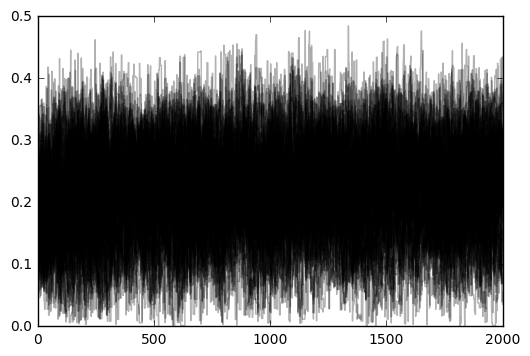

In [192]:
plt.plot(sampler3.chain[:,:,2].T, '-', color='k', alpha=0.3);

In [168]:
import corner

In [193]:
samples = sampler3.chain[:, 50:, :].reshape((-1, ndim))

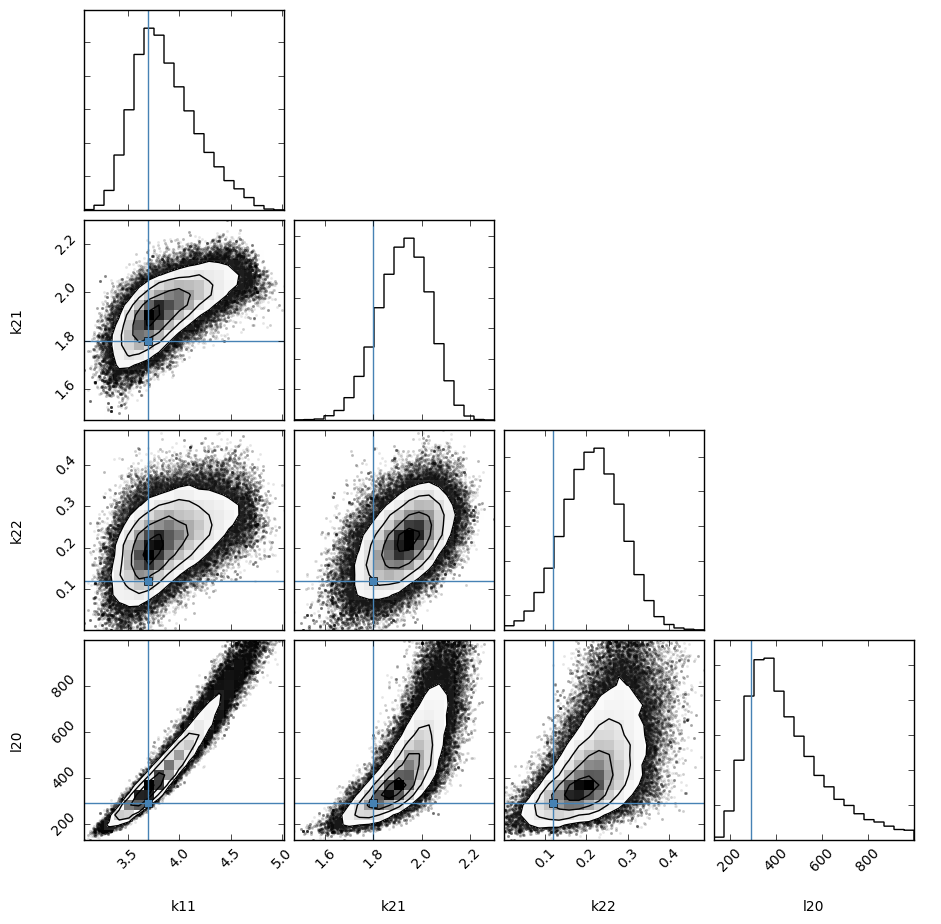

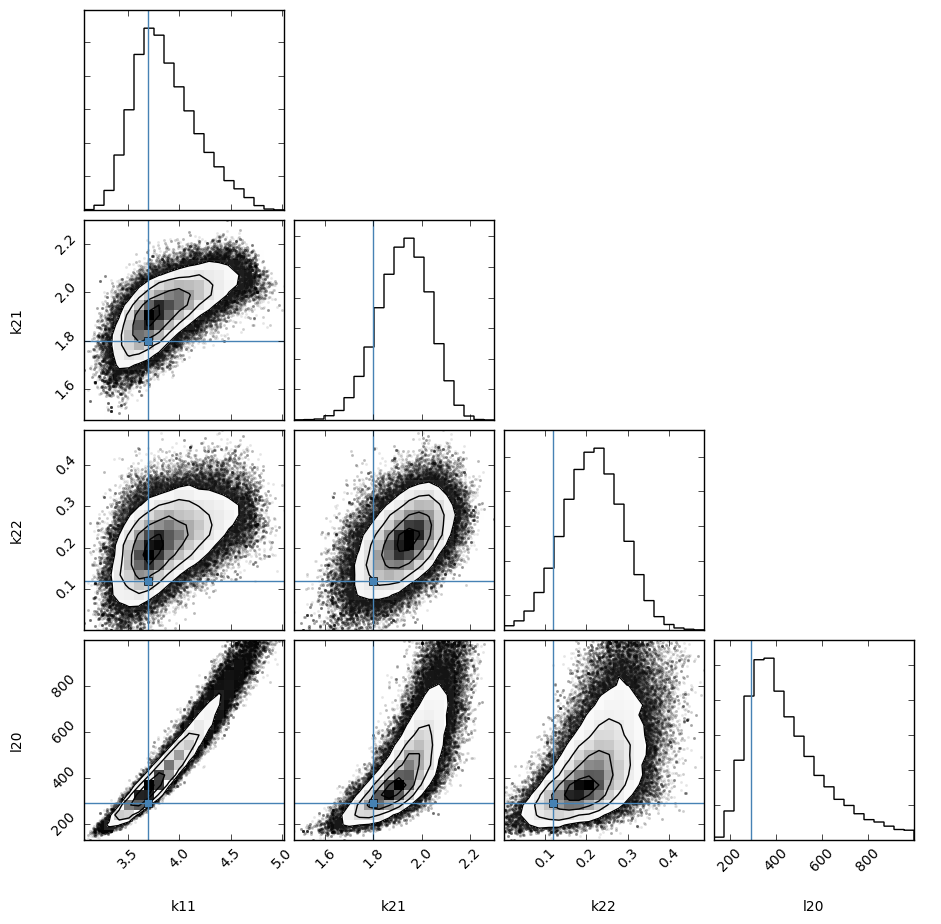

In [194]:
corner.corner(samples,labels=['k11','k21','k22','l20'],truths=[3.7,1.8,0.12,293])

In [176]:
parmvec

[3.7, 1.8, 0.12, 293.0]

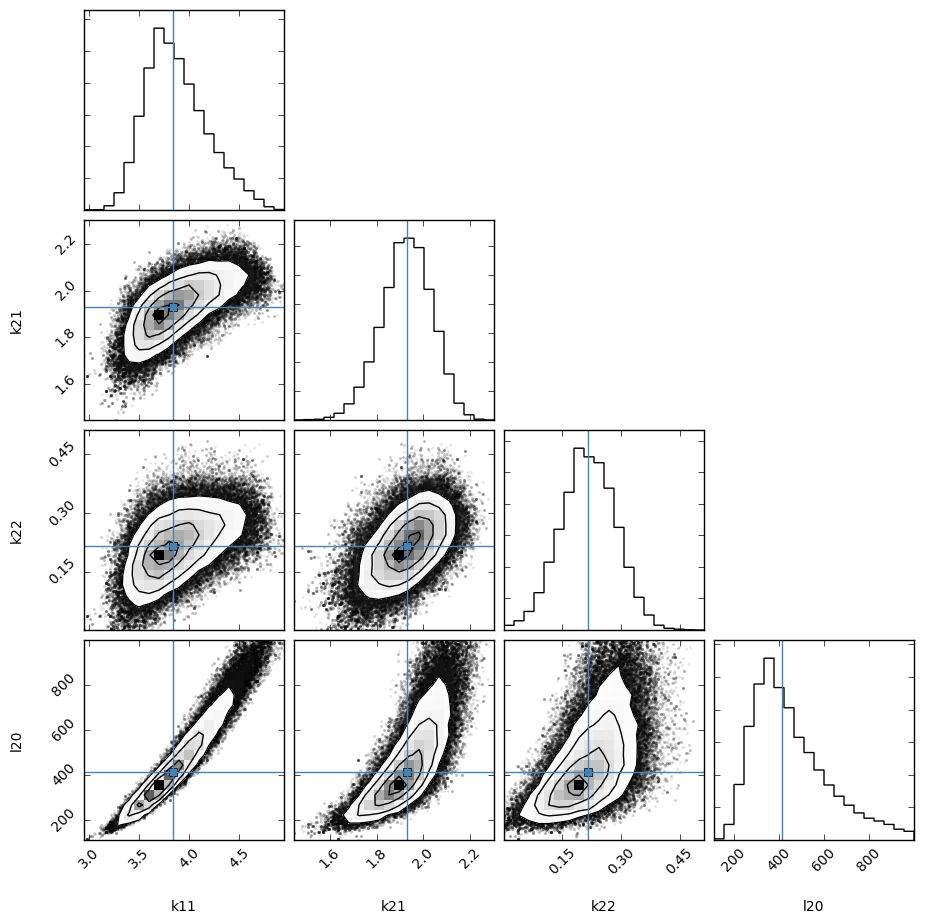

In [198]:
a=corner.corner(res1.flatchain, labels=res1.var_names, truths=list(res1.params.valuesdict().values()))

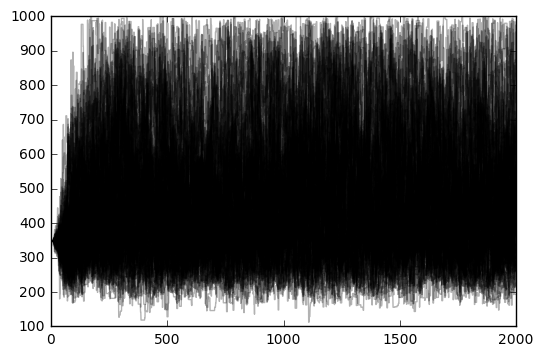

In [199]:
plt.plot(res1.chain[:,:,3].T, '-', color='k', alpha=0.3);

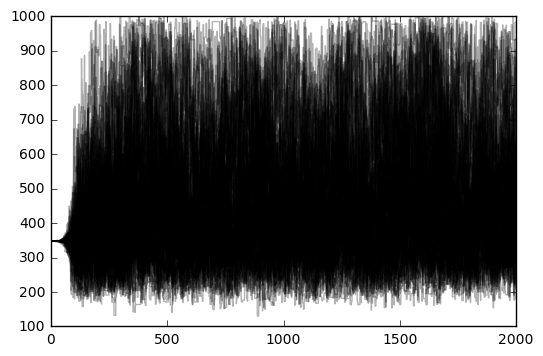

In [200]:
plt.plot(sampler3.chain[:,:,3].T, '-', color='k', alpha=0.3);